## Introduction and Scope¶
It was back in October of 2007 that Joe Gebbia and Brian Chesky decided to throw an air mattress in their living room and set up an "air bed and breakfast" for guests arriving in San Francisco for a major convention. From this lightbulb moment, the founders managed to attract investment and expand their vision to a global empire with a 2020 private valuation of USD $26 billion. Travelers now have the option of staying at short-term vacation rentals or "airbnbs" in many parts of the world, creating a particularly efficient market for hosts who need their listings to be priced competitively. Major cosmopolitan cities like Seattle approaching nearly 10,000 listings will certainly create a demand for accurate price prediction and forecasting.

This analysis will highlight specific elements of the "Seattle Airbnb Listing" Dataset from 2018 which features 7,576 listings with 18 variables, scraped and maintained by Tom Slee, and available for download on Kaggle.

In this fun and hopefully insightful exploration, we will begin by examining the unrefined data and perform any necessary tidying of the dataset. We will then determine which features provide most insight into price prediction and remove those that only serve to add noise. Data visualization and exploratory data analysis will then be performed on the tidied dataset to inform our modeling.

# Data Preparation and Required Packages:

We will begin by loading the following libraries: tidyverse, readr, data.table, caret, lubridate, glmnet, scales, stringr, dplyr, ggmap, ggcorrplot,
treemapify, rpart, nnet, formatR, rmarkdown, and knitr with the "pacman" package. (If a package below is missing, p_load will automatically download it from CRAN).

In [1]:
if(!require(pacman)) install.packages("pacman", repos = "http://cran.us.r-project.org")
library(pacman)
pacman::p_load(tidyverse, readr, data.table, caret, lubridate, 
               ggthemes, ggplot2, glmnet, scales, stringr, dplyr, ggmap, ggcorrplot, 
               treemapify, rpart, nnet, formatR, rmarkdown, knitr)
library(ggmap)
library(dplyr)

Loading required package: pacman



# Data Load and Preparation:

In [2]:
# Read the CSV file
airbnb <- read_csv("../input/seattle-airbnb-listings/seattle_01.csv", show_col_types = FALSE)

# Rename the ...1 column to X1
airbnb <- airbnb %>% rename(X1 = `...1`)

# Set the number of significant digits to 4
options(digits = 4)

New names:
• `` -> `...1`


I renamed col ...1 as X1 using dplyr

In [3]:
colnames(airbnb)

[1] "X1"                   "room_id"              "host_id"             
 [4] "room_type"            "address"              "reviews"             
 [7] "overall_satisfaction" "accommodates"         "bedrooms"            
[10] "bathrooms"            "price"                "last_modified"       
[13] "latitude"             "longitude"            "location"            
[16] "name"                 "currency"             "rate_type"

# Preliminary Data Exploration and Cleaning:
Check the dimensions of the dataset:

In [4]:
dim(airbnb)


# There are 7576 observations and 18 features

str(airbnb)

[1] 7576   18

spc_tbl_ [7,576 × 18] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ X1                  : num [1:7576] 0 1 2 3 4 5 6 7 8 9 ...
 $ room_id             : num [1:7576] 2318 3335 4291 5682 6606 ...
 $ host_id             : num [1:7576] 2536 4193 35749 8993 14942 ...
 $ room_type           : chr [1:7576] "Entire home/apt" "Entire home/apt" "Private room" "Entire home/apt" ...
 $ address             : chr [1:7576] "Seattle, WA, United States" "Seattle, WA, United States" "Seattle, WA, United States" "Seattle, WA, United States" ...
 $ reviews             : num [1:7576] 21 1 63 462 134 130 401 35 36 76 ...
 $ overall_satisfaction: num [1:7576] 5 NA 4.5 5 4.5 4.5 5 5 5 4.5 ...
 $ accommodates        : num [1:7576] 8 4 2 2 2 2 2 4 3 4 ...
 $ bedrooms            : num [1:7576] 4 2 1 0 1 1 1 2 2 1 ...
 $ bathrooms           : num [1:7576] 2.5 1 1 1 1 3 1 1 1 1 ...
 $ price               : num [1:7576] 250 100 82 49 90 65 78 165 95 115 ...
 $ last_modified       : POSIXct[1:7576], format: "2018-12-20

We note that there 18 features of numeric, character, and POSIXct classes. We also notice that there is already one visible NA value in the "overall_satisfaction" feature.

# Data Cleaning:
Coerce airbnb tibble into a data frame for later partitioning purposes:

In [5]:
airbnb <-as.data.frame(airbnb)
class(airbnb)

[1] "data.frame"

## Examine whether the data is tidy and if there are indeed any NAs:

In [6]:
sum(is.na(airbnb))

[1] 1475

## Check which features have NAs:

In [7]:
colSums(is.na(airbnb))

X1              room_id              host_id 
                   0                    0                    0 
           room_type              address              reviews 
                   0                    0                    0 
overall_satisfaction         accommodates             bedrooms 
                1473                    0                    0 
           bathrooms                price        last_modified 
                   2                    0                    0 
            latitude            longitude             location 
                   0                    0                    0 
                name             currency            rate_type 
                   0                    0                    0

We find that "overall_satisfaction" has 1473 NAs while bathrooms has 2.

## Create a dataframe na_bar to plot the NAs:

In [8]:
na_vis <- data.frame(t(colSums(is.na(airbnb))))
na_bar <- data.frame(Features = names(na_vis),totals=colSums(na_vis))

## Now let's observe the NA distribution visually:

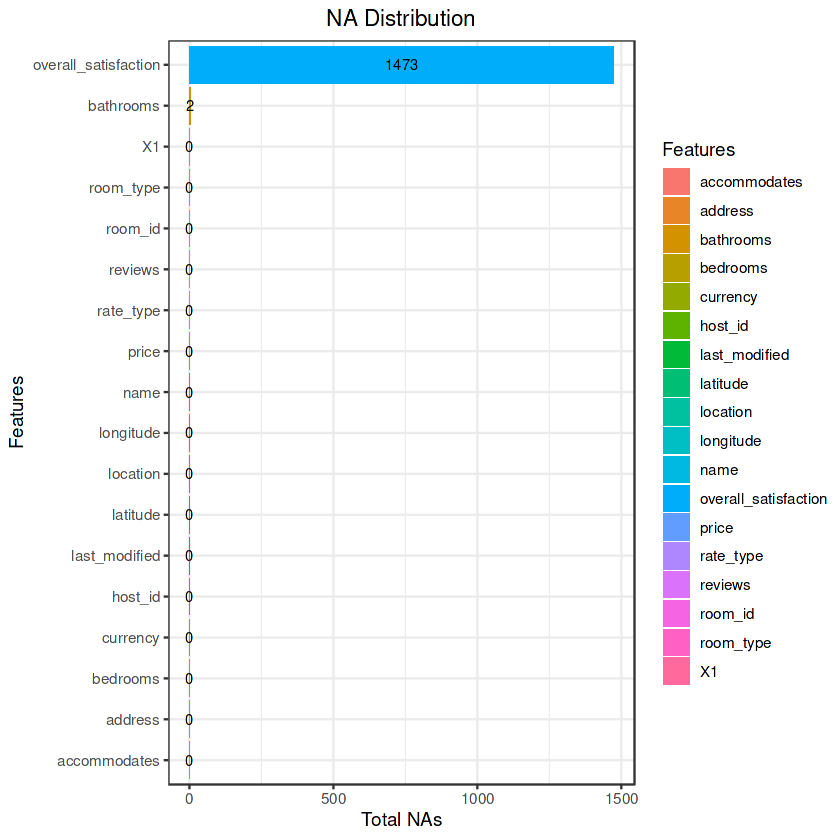

In [9]:
na_bar %>% ggplot(aes(x = reorder(Features, totals), y = totals, fill = Features, label = totals))+
  geom_bar(stat = "identity")+
  ggtitle("NA Distribution")+
  xlab("Features")+
  ylab("Total NAs")+
  coord_flip()+
  geom_text(size = 3, position = position_stack(vjust = 0.5))+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

The visualization confirms there are only two features with missing values and that the all other observations are present.

# NA Removal:

After confirming that there are only 2 features with NAs, (overall_satisfaction 
& bathrooms) we proceed to clean the dataset.
As overall_satisfaction has 1473 NAs, assigning a value of 0 will significantly
skew the ratings negatively. Therefore we will fill the values with the mean
to provide for more accurate predictive pricing in our models.

Convert NAs to the mean value.

In [10]:
airbnb$overall_satisfaction[is.na(airbnb$overall_satisfaction)] <- mean(airbnb$overall_satisfaction, na.rm = TRUE)

Confirm the absence of NAs in this feature:

In [11]:
head(airbnb$overall_satisfaction)

[1] 5.000 4.841 4.500 5.000 4.500 4.500

For the bathrooms feature, there are only 2 NAs and so we set them to zero.

In [12]:
airbnb <-airbnb %>% replace_na(list(bathrooms = 0))

Now confirm the absence of any NAs in the dataset:

In [13]:
sum(is.na(airbnb))

[1] 0

There are 18 features and those less related to price prediction will be dropped to refine our EDA and Modeling Focus:

## Feature: "X1"

In [14]:
head(airbnb$X1)

[1] 0 1 2 3 4 5

"X1" is simply a numerical list for the dataset.

## Features: "room_id" & "host_id"

In [15]:
head(airbnb$room_id)
head(airbnb$host_id)

[1] 2318 3335 4291 5682 6606 9419

[1]  2536  4193 35749  8993 14942 30559

"room_id" & "host_id" are simply numbers arbitrarily assigned to identify rooms 
and hosts.

## Feature: "address"

Check for unique values of the feature "address"

In [16]:
airbnb %>% select(address) %>% distinct()

address
<chr>
"Seattle, WA, United States"
"Kirkland, WA, United States"
"Bellevue, WA, United States"
"Redmond, WA, United States"
"Mercer Island, WA, United States"
"Seattle, WA"
"Renton, WA, United States"
"Ballard, Seattle, WA, United States"
"West Seattle, WA, United States"


Note that there are 27 values with different formats and 12 repeated instances of "Seattle." Any neighborhood of Seattle, the Chinese language version of "Seattle" and listings with only the State of Washington, will all be converted to Seattle. "WA" and "United States" will also be removed as they are redundant.

In [17]:
address_clean <-gsub("Seattle, WA, United States", "Seattle",
  gsub("Kirkland, WA, United States", "Kirkland",
  gsub("Bellevue, WA, United States", "Bellevue",
  gsub("Redmond, WA, United States", "Redmond",
  gsub("Mercer Island, WA, United States", "Mercer Island",
  gsub("Seattle, WA", "Seattle",
  gsub("Renton, WA, United States", "Renton",
  gsub("Ballard, Seattle, WA, United States", "Seattle",
  gsub("West Seattle, WA, United States", "Seattle",
  gsub("Medina, WA, United States", "Medina",
  gsub("Newcastle, WA, United States", "Newcastle",
  gsub("Seattle , WA, United States", "Seattle",
  gsub("Ballard Seattle, WA, United States", "Seattle",
  gsub("Yarrow Point, WA, United States", "Yarrow Point",
  gsub("Clyde Hill, WA, United States", "Clyde Hill",
  gsub("Tukwila, WA, United States", "Tukwila",
  gsub("Seattle, Washington, US, WA, United States", "Seattle",
  gsub("Capitol Hill, Seattle, WA, United States", "Seattle",
  gsub("Kirkland , Wa, United States", "Kirkland",
  gsub("Hunts Point, WA, United States", "Hunts Point",
  gsub("Seattle, DC, United States", "Seattle",
  gsub("Seattle, United States", "Seattle",
  gsub("Vashon, WA, United States", "Vashon",
  gsub("Kirkland , WA, United States", "Kirkland",
  gsub("Bothell, WA, United States", "Bothell",
  gsub("Washington, WA, United States", "Seattle",
      airbnb$address))))))))))))))))))))))))))

Replace the Chinese version of "Seattle" separately using regex:

In [18]:
address_clean2 <-gsub(".*WA*.", "Seattle", address_clean)

Reassign the column to the feature "address":

In [19]:
airbnb$address <-gsub("Seattle, United States", "Seattle", 
                 gsub("Seattle United States", "Seattle", address_clean2))

Now confirm there are only 14 different cities and sort by the greatest numbers of listings:

In [20]:
city_list <-airbnb %>% group_by(address) %>% summarize(listing_sum = n()) %>%
  arrange(-listing_sum)
city_list

address,listing_sum
<chr>,<int>
Seattle,6791
Bellevue,322
Kirkland,202
Redmond,110
Mercer Island,50
Newcastle,49
Renton,39
Medina,4
Bothell,2


###: Let's explore a data visualization to confirm this:

Note: As the remaining locations are all cities, the feature "address" will 
later be renamed "city."

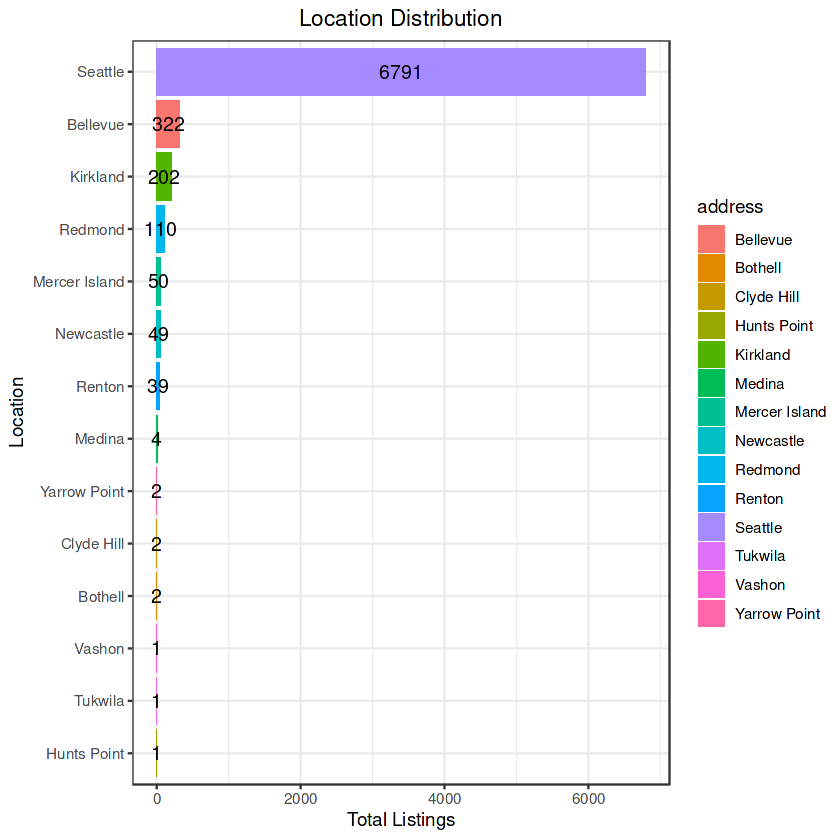

In [21]:
city_list %>% 
  ggplot(aes(x = reorder(address, listing_sum), y = listing_sum, 
                         fill = address, label = listing_sum))+
                         geom_bar(stat = "identity")+
                         ggtitle("Location Distribution")+
                         xlab("Location")+
                         ylab("Total Listings")+
                         coord_flip()+
                         geom_text(size = 4, 
                                   position = position_stack(vjust = 0.5))+
                         theme_bw()+
                         theme(plot.title = element_text(hjust = 0.5))

It is clear the vast majority of listings are in Seattle (6791).

## Feature: "last_modified"

The "last_modified" feature refers to the date a listing was updated and 
nearly all values occur on 2018-12-20, telling us very little about the data,
therefore this feature will be removed.

In [22]:
head(airbnb$last_modified)

[1] "2018-12-20 03:46:14 UTC" "2018-12-20 04:08:45 UTC"
[3] "2018-12-20 03:04:19 UTC" "2018-12-20 04:11:25 UTC"
[5] "2018-12-20 03:12:38 UTC" "2018-12-20 04:08:20 UTC"

## Feature: "location"

The "location" feature will be removed in favor of using "latitude" & "longitude."

In [23]:
head(airbnb$location)

[1] "0101000020E6100000D449B6BA9C925EC0416326512FCE4740"
[2] "0101000020E61000006FBBD05CA7915EC04DF564FED1C34740"
[3] "0101000020E6100000BDAB1E300F945EC0FB93F8DC09D84740"
[4] "0101000020E6100000FCC7427408975EC009E1D1C611C34740"
[5] "0101000020E6100000D47D00529B955EC07782FDD7B9D34740"
[6] "0101000020E6100000145D177E70945EC0522B4CDF6BC64740"

## Feature: "name"

The "name" feature will be removed as it is a categorical description of each listing.

In [24]:
head(airbnb$name)

[1] "Casa Madrona - Urban Oasis, 1 block from the Park!"
[2] "Sweet Seattle Urban Homestead 2 Bdr"               
[3] "Sunrise in Seattle Master Suite"                   
[4] "Cozy Studio, min. to downtown -WiFi"               
[5] "Fab, private seattle urban cottage!"               
[6] "Glorious sun room w/ memory foambed"

## Feature: "currency"

The "currency" feature will be dropped as all rates are in US Dollars.

In [25]:
airbnb %>% select(currency) %>% distinct()

currency
<chr>
USD


## Feature: "rate_type"

Check for distinct values of "rate_type":

In [26]:
airbnb %>% select(rate_type) %>% distinct()

rate_type
<chr>
nightly


After confirming only one unique value, "nightly," we determine this feature can be removed.

# Create the cleaned dataset:

Remove the above mentioned features and rename the columns:


In [27]:
airbnb <-airbnb %>% select(-c(X1, room_id, host_id, last_modified,
                              location, name, currency, rate_type)) %>%
                    rename(city = address, rating = overall_satisfaction,
                           reviews_sum = reviews)

Reorder the columns:

In [28]:
airbnb <-airbnb[,c(8, 2, 4, 3, 1, 6, 7, 5, 9, 10)]

Confirm the features have been tidied and reordered with only 10 features:


In [29]:
names(airbnb)

[1] "price"        "city"         "rating"       "reviews_sum"  "room_type"   
 [6] "bedrooms"     "bathrooms"    "accommodates" "latitude"     "longitude"

Check the first few values of the cleaned dataset:

In [30]:
head(airbnb)

,price,city,rating,reviews_sum,room_type,bedrooms,bathrooms,accommodates,latitude,longitude
,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,250,Seattle,5.000,21,Entire home/apt,4,2.5,8,47.61,-122.3
2,100,Seattle,4.841,1,Entire home/apt,2,1.0,4,47.53,-122.3
3,82,Seattle,4.500,63,Private room,1,1.0,2,47.69,-122.3
4,49,Seattle,5.000,462,Entire home/apt,0,1.0,2,47.52,-122.4
5,90,Seattle,4.500,134,Entire home/apt,1,1.0,2,47.65,-122.3
6,65,Seattle,4.500,130,Private room,1,3.0,2,47.55,-122.3


# Explanatory Data Analysis:

Now we will begin analyzing the features of our dataset to inform our 
price prediction modeling approach.

## Correlogram:

Remove non-numeric features:

In [31]:
airbnb_num <-airbnb %>% select(-c(city, room_type))

Create the correlation matrix:

In [32]:
airbnb_cor <-cor(airbnb_num)

Plot the Correlogram:

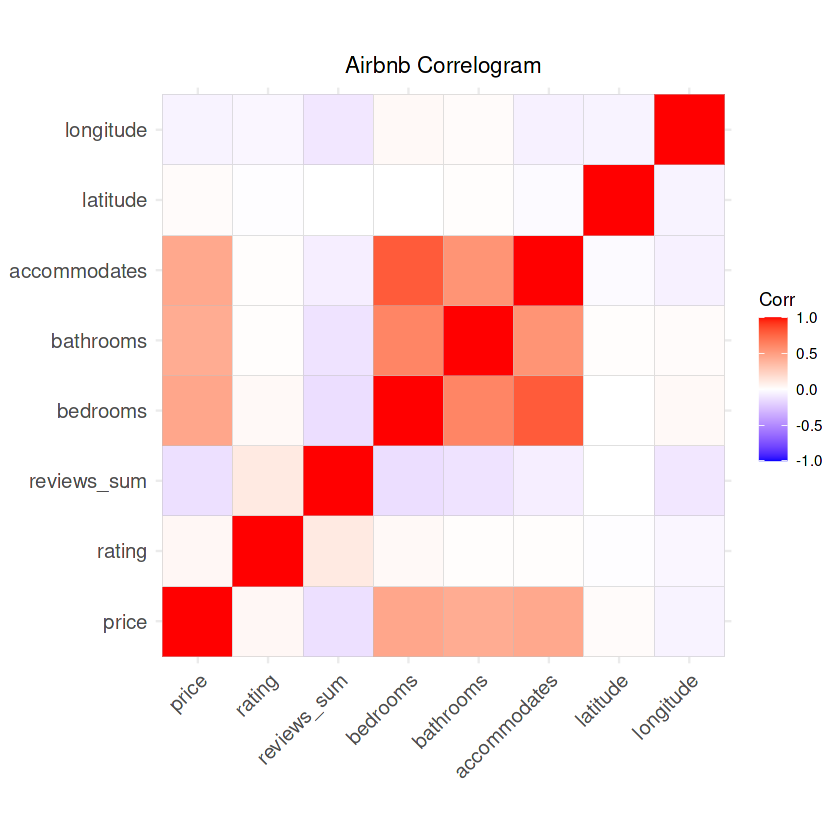

In [33]:
ggcorrplot(airbnb_cor)+
  labs(title = "Airbnb Correlogram")+
  theme(plot.title = element_text(hjust = 0.5))

We discover the price is moderately correlated with the number of people a 
listing can accommodate as well as the number of bedrooms and bathrooms.
Surprisingly, there is little correlation between the location (latitude &
longitude) and price. This relationship will be explored with a scatterplot.

## Density Plot of Price Distribution below $300:

Next we explore a plot of the price distribution below $300 to determine the
most common price ranges.

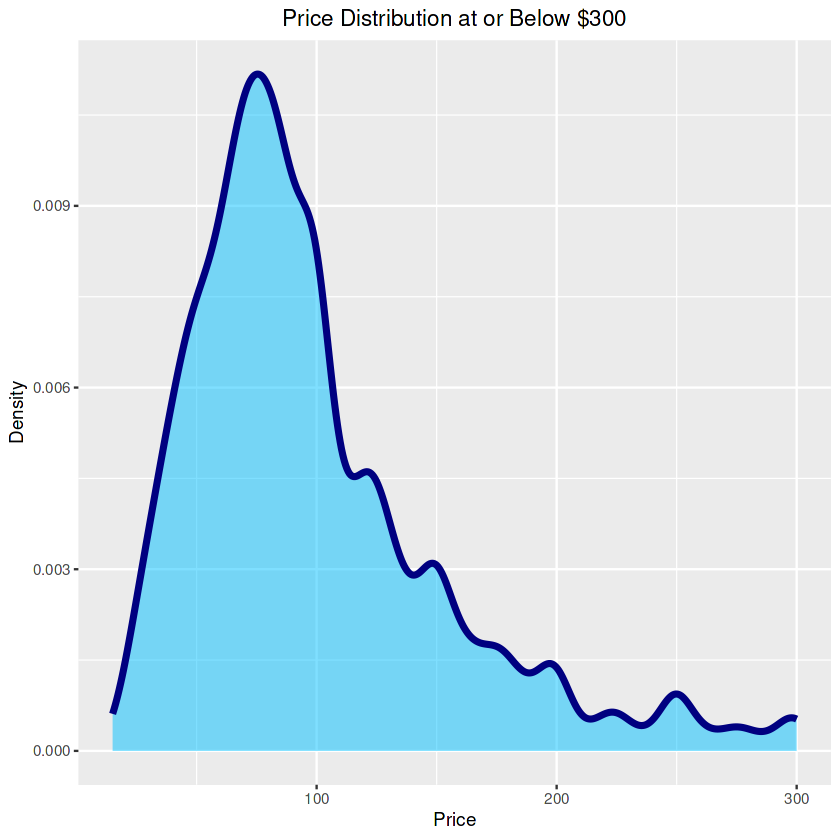

In [34]:
airbnb %>% filter(price <=300) %>% ggplot(aes(price))+
  geom_density(fill = "deepskyblue", linewidth = 1.5, color = "navyblue", alpha = 0.5)+
  xlab("Price")+
  ylab("Density")+
  ggtitle("Price Distribution at or Below $300")+
  theme(plot.title = element_text(hjust = 0.5))

In [35]:
summary(airbnb$price)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     15      65      88     113     125    5900 

According to the above summary, we know that Q3 of the IQR was 125, so let's determine what percentage of prices are less than or equal to 300.

In [36]:
quantile(airbnb$price)
sum(airbnb$price <=300)/length(airbnb$price)

0%  25%  50%  75% 100% 
  15   65   88  125 5900

[1] 0.9652

~ 96.5% of listings are <= $300, therefore we filter our price to remove outliers.

Filter the dataframe airbnb_map:

In [37]:
airbnb_map <-airbnb %>% filter(price <=300)

# Treemap:

Arrange the cities by listing_sum in a dataframe for the Treemap.
Plot the Treemap to visualize the distribution of listings by city:


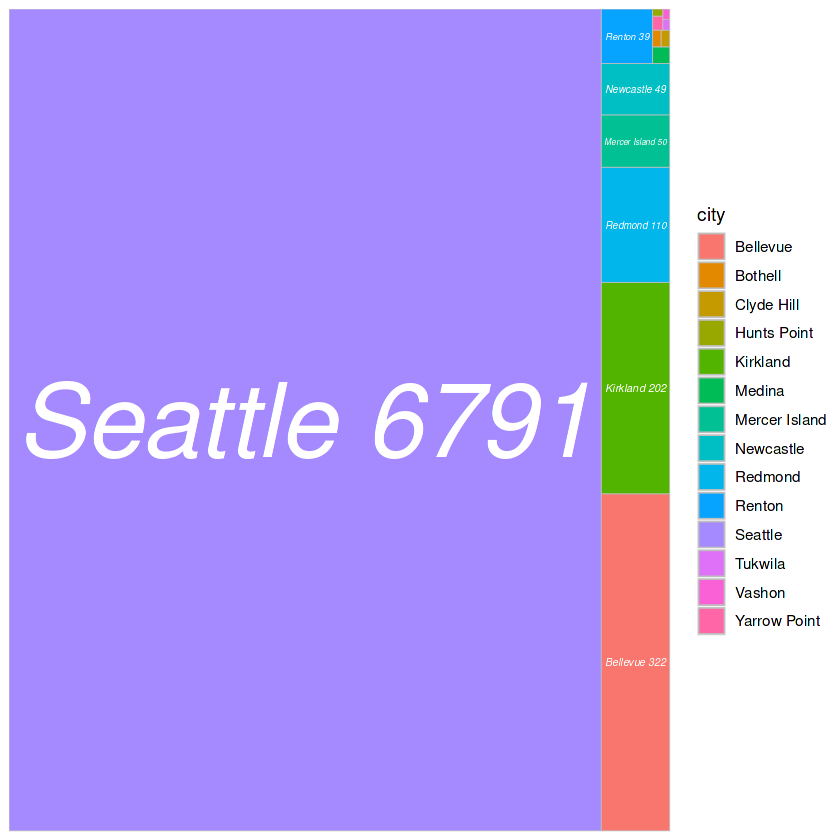

In [38]:
city_distribution <-airbnb %>% group_by(city) %>% summarize(listing_sum = n()) %>%
  arrange(-listing_sum)
# Add column "tmlab" for Treemap labels
city_distribution <-city_distribution %>% 
  unite("tmlab", city:listing_sum, sep = " ", remove = FALSE)
# Plot a Treemap to visualize the distribution of listings by city:
city_distribution %>% ggplot(aes(area = listing_sum, fill = city, label = tmlab))+
  geom_treemap()+
  geom_treemap_text(fontface = "italic", col = "white", place = "center",
                    grow = TRUE)

The Treemap confirms the overwhelming number of listings in Seattle compared to the other cities.

## Visualize Price by City:



In [39]:
city_price <-airbnb %>% group_by(city) %>% 
  summarize(mean_price = mean(price),
            listing_sum = n()) %>%
  arrange(-mean_price) %>% mutate(mean_price = sprintf("%0.1f", mean_price))
# Coerce the "mean_price" to integer:
city_price$mean_price <-as.integer(city_price$mean_price)

Plot the Visualization:


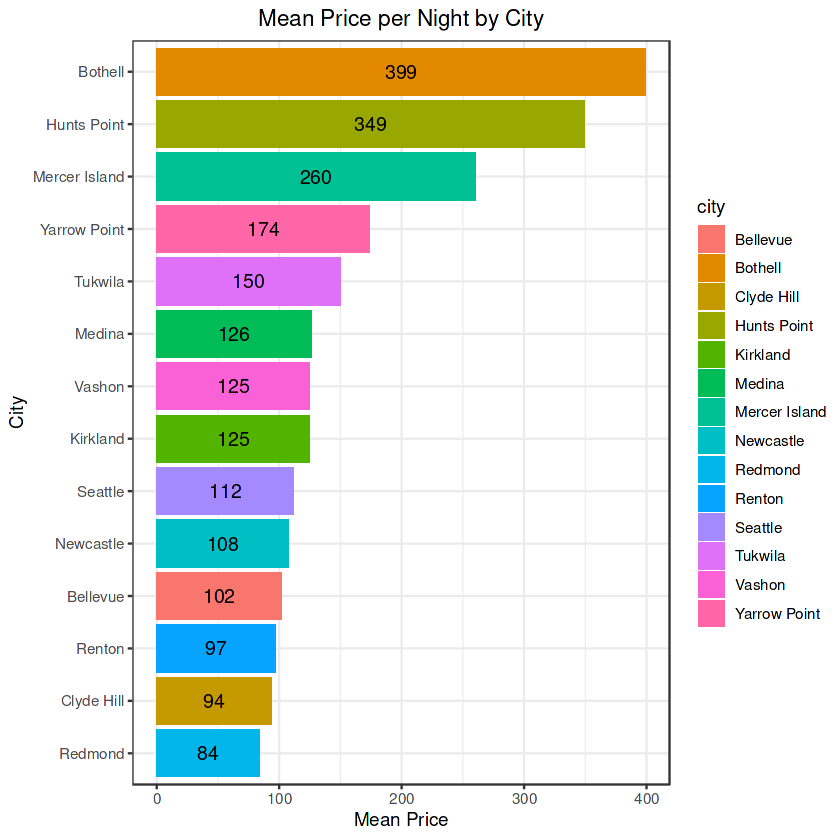

In [40]:
city_price %>% ggplot(aes(x = reorder(city, mean_price), y = mean_price, 
                         fill = city, label = mean_price))+
  geom_bar(stat = "identity")+
  coord_flip()+
  xlab("City")+
  ylab("Mean Price")+
  ggtitle("Mean Price per Night by City")+
  geom_text(size = 4, 
            position = position_stack(vjust = 0.5))+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

According to this visualization, it would seem location (latitude & longitude) 
is highly correlated with price. Let's explore why this was not the case in our
correlogram. Let's replot the visualization with the sum of listings included.

## Visualize Mean Price & Sum of Listings by City:


In [41]:
# Create dataframe "city_comp" with a percentage column:
city_comp <-city_price %>% 
  mutate(percentage = sprintf("%0.3f",(listing_sum/sum(listing_sum)*100)))
# Add the % symbol to the percentage feature:

city_comp$percentage <- paste(city_comp$percentage, "%")

# Combine the mean price & percentage values into one column:
city_comp <-city_comp %>% 
  unite("citylab", mean_price, percentage, sep = ", ", remove = FALSE)

Plot the visualization with Mean Price & Percentage of Total Listings:

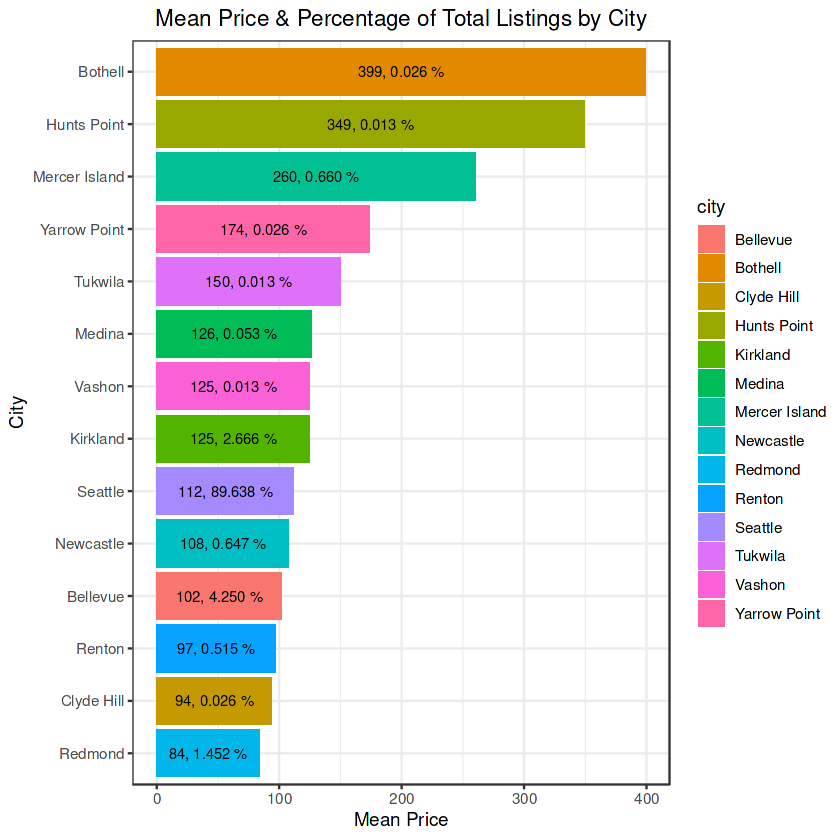

In [42]:
city_comp %>% 
  ggplot(aes(x = reorder(city, mean_price), y = mean_price, 
                          fill = city, label = citylab))+
  geom_bar(stat = "identity")+
  coord_flip()+
  xlab("City")+
  ylab("Mean Price")+
  ggtitle("Mean Price & Percentage of Total Listings by City")+
  geom_text(size = 3, position = position_stack(vjust = 0.5))+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

We learn that over 89% of listings are in Seattle with a mean price of 
112 / night. The top 7 listings with the highest average prices barely equal
1% (~0.8%) of the total listings though their average price is 226.10 / night.
The lower percentage of total listings in these locations at the higher 
price range, with almost 90% of listings in Seattle likely explains the 
lower correlation between price and location in this dataset.

## Feature: "rating"
The "rating" feature is based on a numerical rating from 0 to 5 with a
mean of 4.841. As this is a relatively high mean rating, we will explore its
relationship mean price by city to determine its price prediction potential.

Create the dataframe rating_comp to compare mean price and rating.
Set the parameters for the dual-axis plot.
Plot the Barplot (Rating) with Overlapping Line (Price in RED):

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


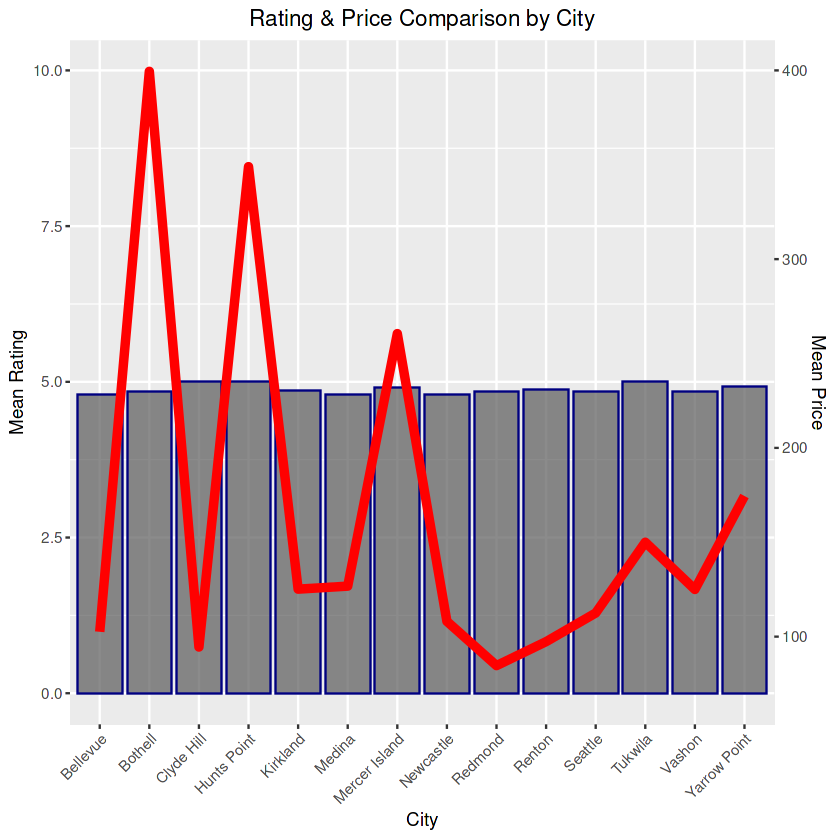

In [43]:
rating_comp <-airbnb %>% group_by(city) %>% 
 summarize(mean_rating = mean(rating), mean_price = mean(price)) %>%
  select(city, mean_rating, mean_price)

# Set the parameters for the dual-axis plot:
ylim_1 <-c(0,10)
ylim_2 <-c(70, 400)
b <- diff(ylim_1)/diff(ylim_2)
a <- b*(ylim_1[1] - ylim_2[1])

# Plot the Barplot (Rating) with Overlapping Line (Price):
ggplot(rating_comp, aes(city, group =1))+
  geom_bar(aes(y=mean_rating), stat="identity", color = "navyblue", alpha=.7)+
  geom_line(aes(y = a + mean_price*b), color = "red", size = 2)+
  scale_y_continuous(name = "Mean Rating", 
                     sec.axis = sec_axis(~ (. - a)/b, name = "Mean Price"))+
  xlab("City")+
  ggtitle("Rating & Price Comparison by City")+
  theme(axis.text.x = element_text(angle = 45, hjust=1),
        plot.title = element_text(hjust = 0.5))

Check the range of mean ratings by city:

In [44]:
range(rating_comp$mean_rating)

[1] 4.796 5.000

We notice that due to the tight range of mean ratings by city, there is a very 
low correlation between price and rating. For example, a high price does not
guarantee a higher rating as the most expensive city Bothell does not have the
highest rating. Furthermore, cities with lower average prices tend to have
mean ratings higher than Bothell.

## Feature: "reviews_sum"

Now let's compare the total number of reviews and different price ranges:

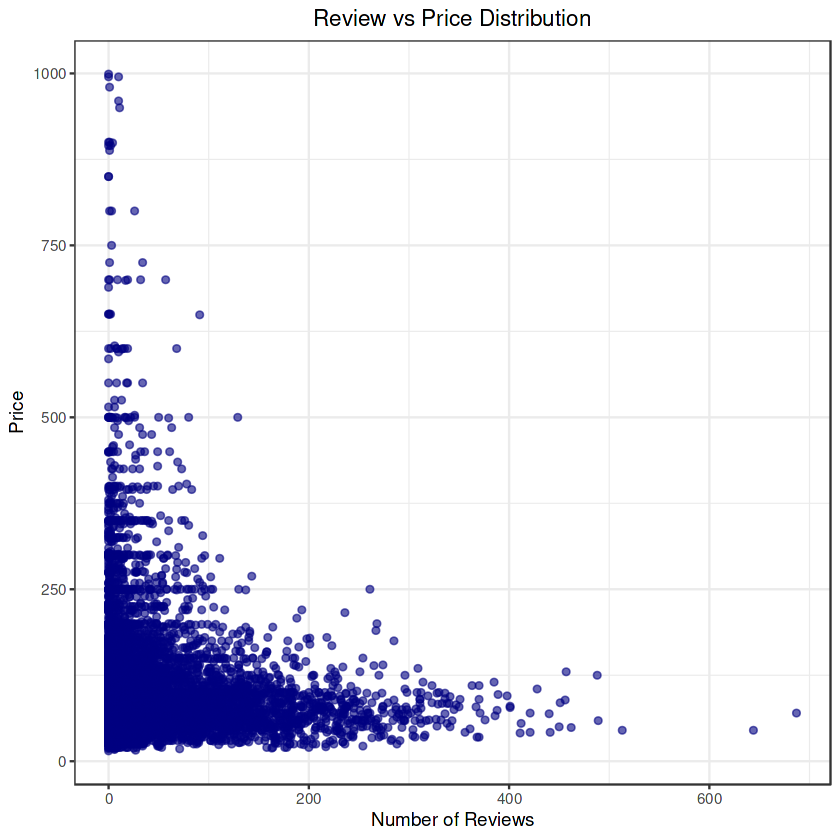

In [45]:
airbnb %>% filter(price <= 1000) %>% 
  ggplot(aes(x = reviews_sum, y = price))+ 
  geom_point(color="navyblue", alpha = 0.6, size = 1.5)+
  xlab("Number of Reviews")+
  ylab("Price")+
  ggtitle("Review vs Price Distribution")+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

The visualization shows us that there are generally fewer reviews for listings
with higher prices (above ~$500). We can infer that this is because there are
fewer stays at these higher-priced listings.

## Feature: "room_type"
There are 3 different room types: Entire home / apartment, Private Room, &
Shared Room.
Let's explore the relationship between room type and average price:

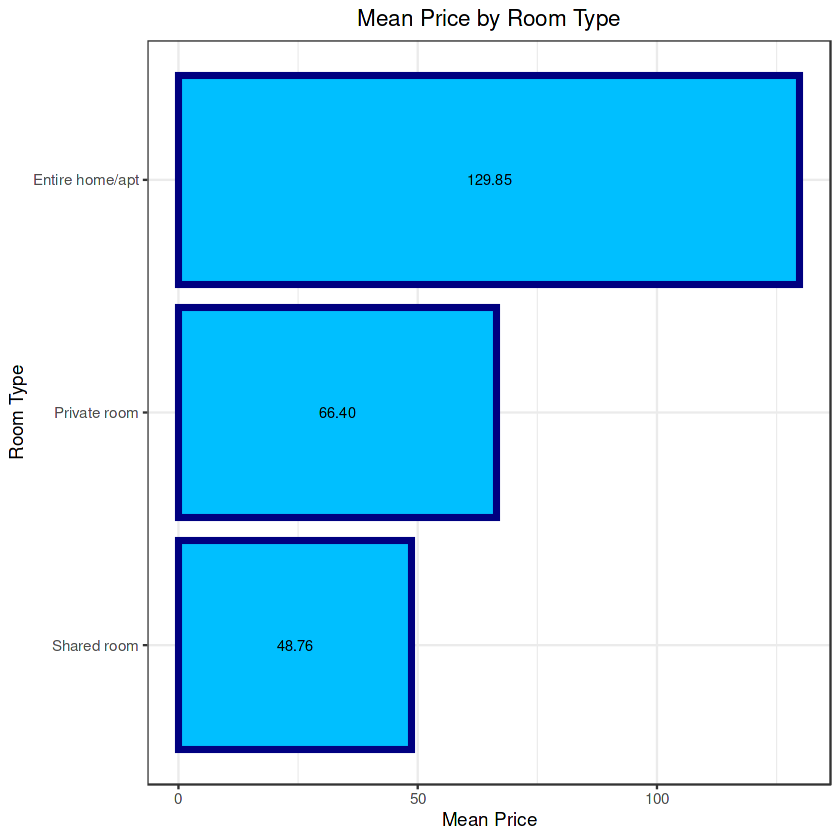

In [46]:
airbnb %>% group_by(room_type) %>%
  summarize(mean_price = mean(price)) %>%
  ggplot(aes(reorder(room_type, mean_price), 
             y = mean_price, label=sprintf("%0.2f", 
                                           round(mean_price, digits = 2))))+ 
  geom_bar(stat = "identity", color = "navyblue", 
           size = 1.5, fill = "deepskyblue")+
  coord_flip()+
  xlab("Room Type")+
  ylab("Mean Price")+
  ggtitle("Mean Price by Room Type")+
  geom_text(size = 3,
            position = position_stack(vjust = 0.5))+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

## Feature: "bathrooms"

Bathrooms range in quantity from 0 to 8 in increments of 0.5 per listing.
Let's explore a visualization that delineates the mean price per listing based
on the number of bathrooms available:

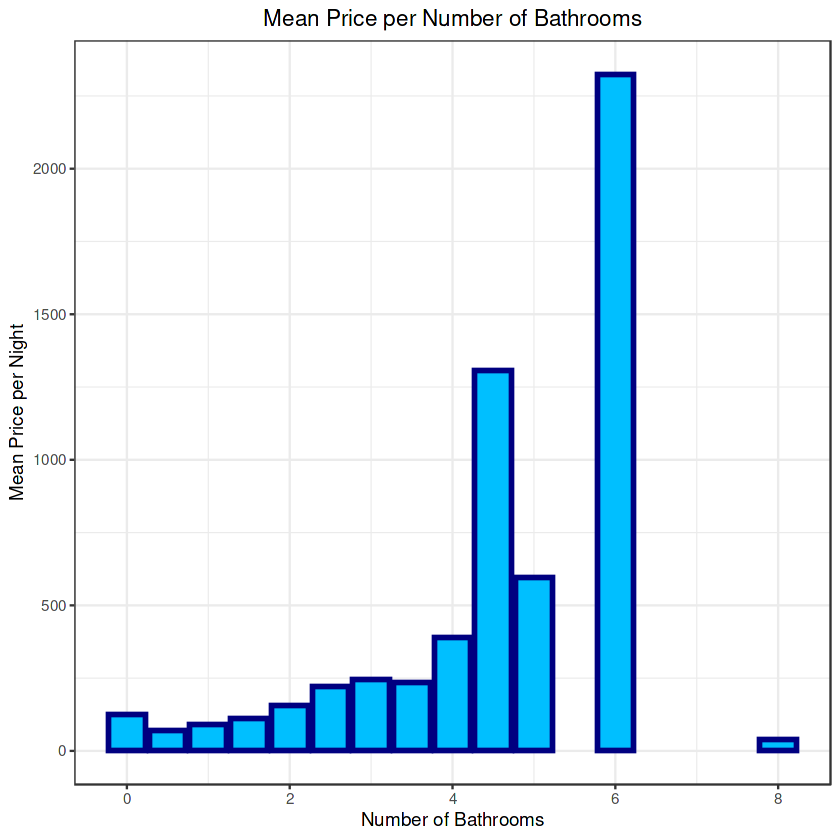

In [47]:
airbnb %>% group_by(bathrooms) %>% summarize(mean_price = mean(price)) %>%
  ggplot(aes(bathrooms, mean_price))+
  geom_bar(stat = "identity", fill = "deepskyblue", color = "navyblue", size = 1.2)+
  xlab("Number of Bathrooms")+
  ylab("Mean Price per Night")+
  ggtitle("Mean Price per Number of Bathrooms")+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

We notice that generally, the higher the number of bathrooms per listing, the
higher the price. Interestingly, listings with 0 bathrooms actually had a
higher average price than listings with 0.5 - 1.5, and 8 bathrooms! It is
clear that a listings with 8 bathrooms having a lower mean price than those
with one bathroom is suspect and most certainly an outlier.

Now let's visualize a barplot with the total number of listings
per bathroom count:

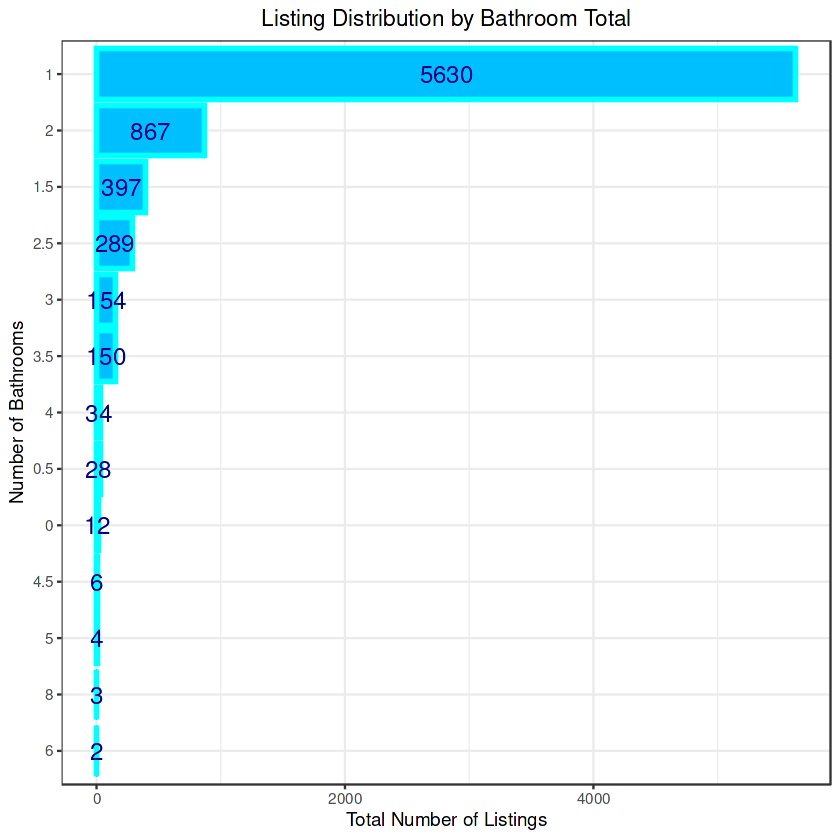

In [48]:
airbnb %>% group_by(bathrooms) %>% summarize(sum_bath = length(bathrooms)) %>%
  ggplot(aes(reorder(bathrooms, sum_bath), y=sum_bath, label = sum_bath))+
  geom_bar(stat = "identity", fill = "deepskyblue", color = "cyan", size = 1.2)+
  coord_flip()+
  geom_text(size = 5, color = "navyblue",
            position = position_stack(vjust = 0.5))+
  xlab("Number of Bathrooms")+
  ylab("Total Number of Listings")+
  ggtitle("Listing Distribution by Bathroom Total")+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

It is evident that the vast majority of listings (~74%) have only 1 bathroom.

# Feature: "bedrooms"

The bedrooms feature details the number of bedrooms available per listing and
has been shown in our correlogram to be positively correlated with the price
per listing.

Let's explore a visualization that details the mean price per listing versus
the number of beds available:

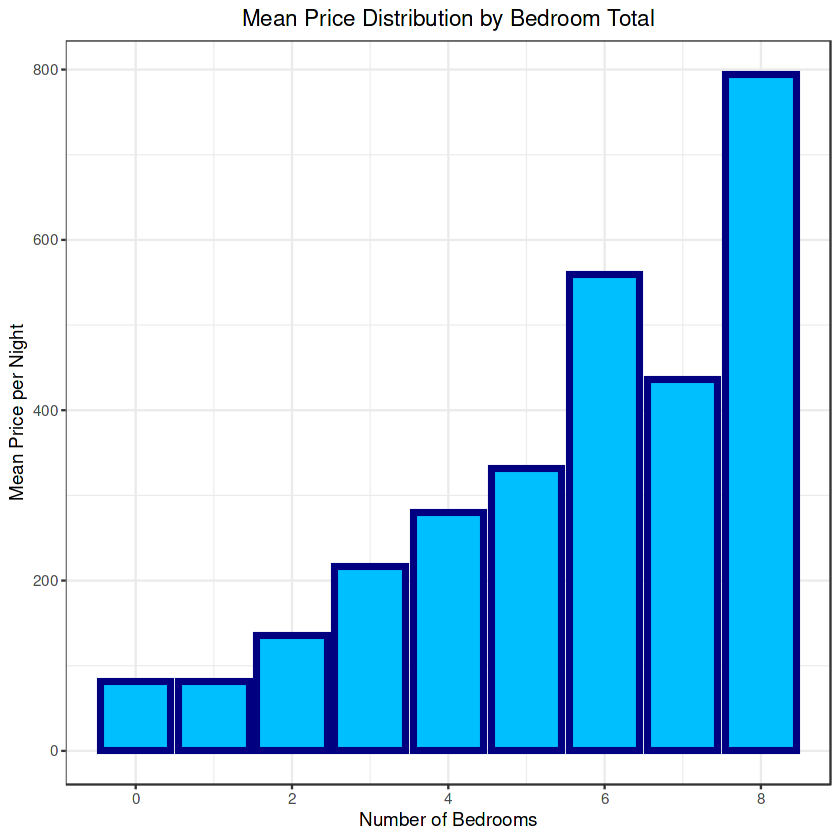

In [49]:
airbnb %>% group_by(bedrooms) %>% 
  summarize(mean_price = mean(price)) %>%
  ggplot(aes(bedrooms, mean_price))+
  geom_bar(stat = "identity", 
           color = "navyblue", fill = "deepskyblue", size = 1.5)+
  xlab("Number of Bedrooms")+
  ylab("Mean Price per Night")+
  ggtitle("Mean Price Distribution by Bedroom Total")+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

The visualization confirms the moderately positive correlation between price 
and number of bedrooms. This feature is very likely to contribute to the 
accuracy of our price prediction models.

Now let's explore listing quantity by number of bedrooms:

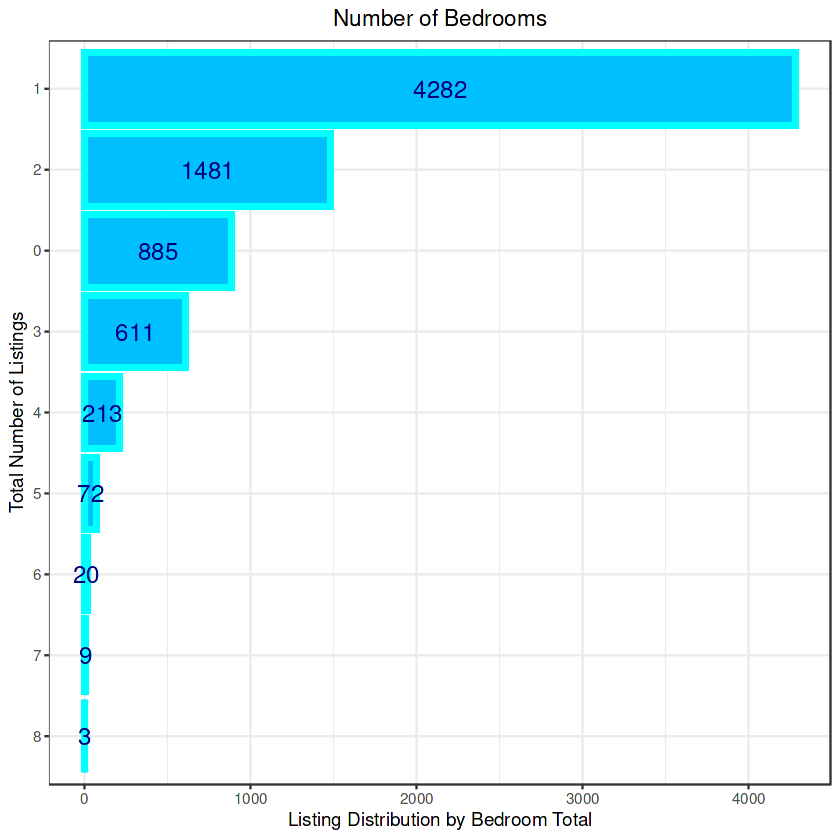

In [50]:
airbnb %>% group_by(bedrooms) %>% summarize(sum_beds = length(bedrooms)) %>%
  ggplot(aes(reorder(bedrooms, sum_beds), y = sum_beds, label = sum_beds))+
  geom_bar(stat = "identity", 
           color = "cyan", fill = "deepskyblue", size = 1.5)+
  coord_flip()+
  geom_text(size = 5, color = "navyblue",
            position = position_stack(vjust = 0.5))+
  xlab("Total Number of Listings")+
  ylab("Listing Distribution by Bedroom Total")+
  ggtitle("Number of Bedrooms")+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

1 bedroom listings lead the distribution with 4,282 listings (56.5%). As a
result of the above findings, there is a high probability of a guest renting 
a 1 bedroom, 1 bath unit.

## Feature: "accommodates"

Generally, we might predict that the mean price of a listing per night would 
increase if it could provide space for more guests.

Let's explore this idea with a visualization:

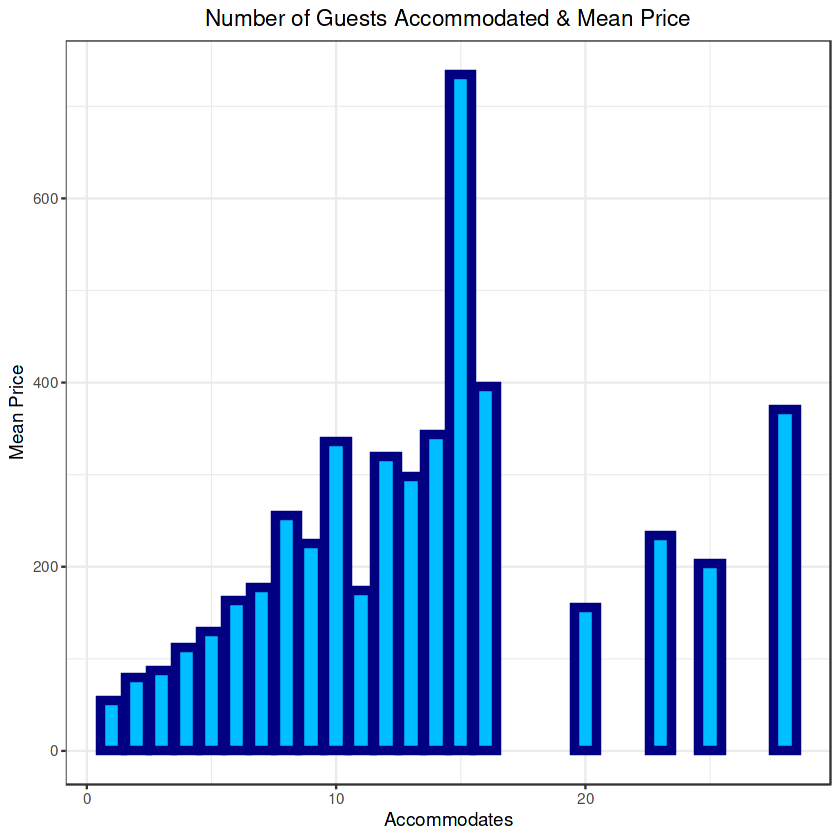

In [51]:
airbnb %>% group_by(accommodates) %>% summarize(mean_price = mean(price)) %>%
  ggplot(aes(accommodates, mean_price))+ 
  geom_bar(stat = "identity", color = "navyblue", 
           size = 2, fill = "deepskyblue")+
  xlab("Accommodates")+
  ylab("Mean Price")+
  ggtitle("Number of Guests Accommodated & Mean Price")+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

The visualization confirms there is a general increase in average price as
the number of guests able to be accommodated increases.

Finally, let's check the number of people most units can accommodate:

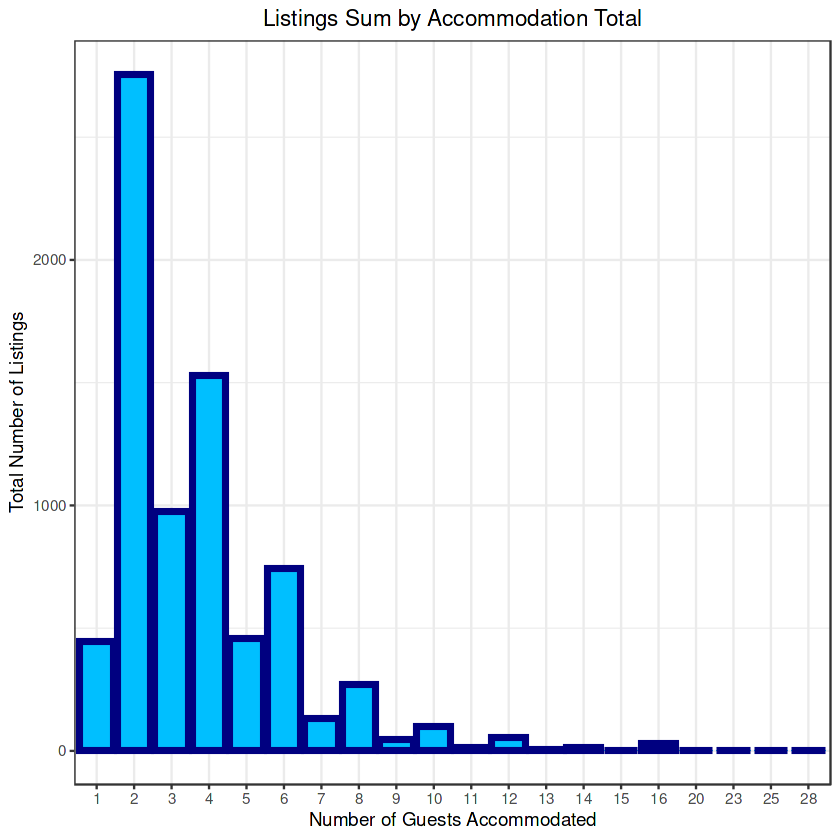

In [52]:
airbnb %>% group_by(accommodates) %>% 
  summarize(sum_acc = length(accommodates)) %>% 
  ggplot(aes(x = factor(accommodates), y = sum_acc))+
  geom_bar(stat = "identity", color = "navyblue", fill = "deepskyblue", size = 1.5)+
  xlab("Number of Guests Accommodated")+
  ylab("Total Number of Listings")+
  ggtitle("Listings Sum by Accommodation Total")+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

The majority of listings can accommodate 4 or fewer guests with 2 guests being 
the most popular.

## EDA Conclusion:

The correlogram starts us off by highlighting important relationships between
price, bedrooms, bathrooms, and accommodates which are later confirmed by 
visualizations and quantitative analysis. Additionally, we learn location (using
latitude and longitude), rating, and reviews sum all have certain potential to
increase the accuracy of our predictive models if included in our formula. 
"Room_type", an important feature, could be vectorized into a quantitative 
scale, though for the purposes of the following regression models, will be
revisited in our conclusion.

# Modeling:
Partition Airbnb Combined & Test Sets for the Final Model:

`airbnb_combined` will be used to fit the Final Model as it is equal to the 
sum of the training and validation sets and equal to 90% of the total data.
`airbnb_test`, comprised of the remaining 10% of the data, will be used as 
the test set for the final model.

In [53]:
# Set the seed for reproducibility:
set.seed(123)
test_index <- createDataPartition(y = airbnb$price, times = 1, p = 0.1, list = FALSE)
airbnb_combined <- airbnb[-test_index,]
airbnb_test <- airbnb[test_index,]
# Remove test_index:
rm(test_index)


Split Training and Validation Sets from airbnb_combined to train our models:
`airbnb_train` will constitute 80% and validation the remaining 20% of
`airbnb_combined`.

In [54]:
# Set the seed for reproducibility:
set.seed(123)
test_index <- createDataPartition(y = airbnb_combined$price, times = 1, 
                                  p = 0.2, list = FALSE)
airbnb_train <- airbnb_combined[-test_index,]
validation <- airbnb_combined[test_index,]

# Remove test_index:
rm(test_index)


## The Loss Function / RMSE is defined as follows:
Results will be based on calculating the Root Mean Square Error on the test 
set. The RMSE weighs large errors more heavily and tends to be the preferred measurement of error in regression models when large errors are undesirable.

Mathematically, it is defined as:  
$$\sqrt{\frac{1}{N}\sum_{u,i}(\hat{y}_{u,i}-y_{u,i})^2}$$  


In [55]:
RMSE <-function(true_ratings, predicted_ratings){
  sqrt(mean((true_ratings - predicted_ratings)^2))
}

## The Loss Function / RMSE is defined as follows:
Results will be based on calculating the Root Mean Square Error on the test 
set. The RMSE weighs large errors more heavily and tends to be the preferred measurement of error in regression models when large errors are undesirable.

Mathematically, it is defined as:  
$$\sqrt{\frac{1}{N}\sum_{u,i}(\hat{y}_{u,i}-y_{u,i})^2}$$  


In [56]:
RMSE <-function(true_ratings, predicted_ratings){
  sqrt(mean((true_ratings - predicted_ratings)^2))
}

In [57]:
airbnb_train_median <-median(airbnb_train$price)

# Table the Results:


In [58]:
MM_RMSE <-RMSE(validation$price, airbnb_train_median)
results_table <-tibble(Model_Type = "Baseline Median", 
                       RMSE = MM_RMSE) %>% 
  mutate(RMSE = sprintf("%0.2f", RMSE))
knitr::kable(results_table)



|Model_Type      |RMSE   |
|:---------------|:------|
|Baseline Median |181.97 |

The Baseline Model achieves an RMSE of 99.05.

## Vectorize the optimal formula that will be used for most Models:

The formula has been determined by the above EDA as well as experimentation
on the training models. Additionally, the formula will reduce lines of code.


In [59]:
airbnb_form <-price ~ rating + reviews_sum + bedrooms + bathrooms + 
  accommodates + latitude + longitude

## Linear Model:

With linear regression, we attempt to predict a (dependent) $y$ variable, in this case "price", with the(independent) input $x$ variables: rating + reviews_sum + bedrooms + bathrooms + accommodates + latitude + longitude in order to build a 
statistically significant model with a p-value less than .05.


In [60]:
lm_airbnb <- lm(airbnb_form, data = airbnb_train)

# Create the prediction
lm_preds <-predict(lm_airbnb, validation)

# Table the Results
LM_RMSE <-RMSE(validation$price, lm_preds)
results_table <-tibble(Model_Type = c("Baseline Median", "Linear"), 
                       RMSE = c(MM_RMSE, LM_RMSE)) %>% 
  mutate(RMSE = sprintf("%0.2f", RMSE))

knitr::kable(results_table)



|Model_Type      |RMSE   |
|:---------------|:------|
|Baseline Median |181.97 |
|Linear          |164.87 |

The Linear Model vastly improves upon the Baseline Model with an RMSE of 73.8.

## Elastic Net Regression with glmnet:

This model introduces regularization on a generalized linear model using
penalized maximum likelihood and tuning optimal alpha and lambda parameters
unlike Lasso and Ridge Regression Models. It combines advantages of both models
by penalizing by the L1 & L2-norms. Mathematically, the estimates can be defined
as follows:

$$\hat{\beta} \equiv \underset{\beta}{\operatorname{argmin}} (\| y-X \beta \|^2 + \lambda_2 \|\beta\|^2 + \lambda_1 \|\beta\|_1)$$


In [61]:
# Set the seed for reproducibility:
set.seed(123)
train_enr <- train(airbnb_form, data = airbnb_train, method = "glmnet",
                   preProcess = c("center", "scale"),
                   tuneLength = 10, trace = FALSE)

# Confirm the optimal alpha and lambda parameters
train_enr$bestTune
# alpha = 0.1, and lambda = 21.24

# Create the Prediction:
elastic_preds <- predict(train_enr, newdata = validation)

# Table the Results
ENR_RMSE <- RMSE(validation$price, elastic_preds)
results_table <- tibble(Model_Type = c("Baseline Median", "Linear",
                                      "Elastic Net Regression"), 
                       RMSE = c(MM_RMSE, LM_RMSE, ENR_RMSE)) %>% 
                       mutate(RMSE = sprintf("%0.2f", RMSE))
knitr::kable(results_table)


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


,alpha,lambda
,<dbl>,<dbl>
3,0.1,0.7436




|Model_Type             |RMSE   |
|:----------------------|:------|
|Baseline Median        |181.97 |
|Linear                 |164.87 |
|Elastic Net Regression |164.88 |

The Elastic Net with Regression underperforms the Linear Model with an RMSE of 74.06.

## Regression Tree Model with rpart:

Regression trees or regression decision trees partition data recursively into smaller, more simplistic partitions where specific models can be applied using 
conditional statements on the predictors. It is generally not as robust as 
models with bootstrap aggregation or Random Forest Models.


In [62]:
# Set the seed for reproducibility:
set.seed(123)
train_rpart <- train(airbnb_form, method = "rpart", data = airbnb_train,
                     tuneGrid = data.frame(cp = seq(0, 0.05, len = 25)),
                     preProcess = c("center", "scale"))

# Check the bestTune to find the final complexity parameter used for the model:
train_rpart$bestTune
# The final cp is 0.00625.

# Create the Prediction:
rt_preds <- predict(train_rpart, newdata = validation)

# Table the Results:
RT_RMSE <- RMSE(validation$price, rt_preds)
results_table <- tibble(
  Model_Type = c("Baseline Median", "Linear", "Elastic Net Regression", "Regression Tree"),
  RMSE = c(MM_RMSE, LM_RMSE, ENR_RMSE, RT_RMSE)
) %>% 
  mutate(RMSE = sprintf("%0.2f", RMSE))

knitr::kable(results_table)


,cp
,<dbl>
3,0.004167




|Model_Type             |RMSE   |
|:----------------------|:------|
|Baseline Median        |181.97 |
|Linear                 |164.87 |
|Elastic Net Regression |164.88 |
|Regression Tree        |150.23 |

The Regression Tree model underperforms the both the Linear Model and
the Elastic Net Regression Model with an RMSE of 76.03.

## Random Forest Model:

Random Forests are similar to the Regression Tree model, though they average 
several random subsets of decision trees in order improve predictive 
performance.

In [63]:
# Set the tuneGrid parameters: 
rf_tune <- expand.grid(.mtry = c(1:3))

# Set the seed for reproducibility:
set.seed(123)
train_rf <- train(airbnb_form, data = airbnb_train,
                  method = "rf", ntree = 150,
                  tuneGrid = rf_tune, nSamp = 1000, 
                  preProcess = c("center", "scale"))

# Check the bestTune:
train_rf$bestTune
# The bestTune is a mtry of 1

# Create the Prediction:
rf_preds <- predict(train_rf, newdata = validation)

# Table the Results
RF_RMSE <- RMSE(validation$price, rf_preds)
results_table <- tibble(Model_Type = c("Baseline Median", "Linear",
                                      "Elastic Net Regression", 
                                      "Regression Tree", "Random Forest"), 
                       RMSE = c(MM_RMSE, LM_RMSE, ENR_RMSE, RT_RMSE,
                                RF_RMSE)) %>% 
  mutate(RMSE = sprintf("%0.2f", RMSE))
knitr::kable(results_table)


,mtry
,<int>
2,2




|Model_Type             |RMSE   |
|:----------------------|:------|
|Baseline Median        |181.97 |
|Linear                 |164.87 |
|Elastic Net Regression |164.88 |
|Regression Tree        |150.23 |
|Random Forest          |154.73 |

The Random Forest significantly improves upon the all previous Models with
an RMSE of 66.57.


## "Bagging Tree" -- Bootstrap Aggregating Model:

Bagging, similar to Random Forest Models, uses aggregation to create more robust
predictions. It is an ensemble method that improves stability over classic 
regression tree models while attempting to minimize overfitting.

In [64]:
# Set the seed for reproducibility:
set.seed(123)
train_bag <- train(airbnb_form, data = airbnb_train, method = "treebag",
                   importance = TRUE, tuneLength = 10, 
                   preProcess = c("center", "scale"))

# Create the Prediction
bag_preds <- predict(train_bag, newdata = validation)

# Table the Results
BAG_RMSE <- RMSE(validation$price, bag_preds)
results_table <- tibble(Model_Type = c("Baseline Median", "Linear",
                                      "Elastic Net Regression", 
                                      "Regression Tree", "Random Forest",
                                      "BAG"), 
                       RMSE = c(MM_RMSE, LM_RMSE, ENR_RMSE, RT_RMSE,
                                RF_RMSE, BAG_RMSE)) %>% 
  mutate(RMSE = sprintf("%0.2f", RMSE))
knitr::kable(results_table)




|Model_Type             |RMSE   |
|:----------------------|:------|
|Baseline Median        |181.97 |
|Linear                 |164.87 |
|Elastic Net Regression |164.88 |
|Regression Tree        |150.23 |
|Random Forest          |154.73 |
|BAG                    |153.70 |

The BAG Model underperforms the Random Forest Model with an RMSE of 68.98.

## kNN Regression Model:

k Nearest Neighbors uses the parameter $k$ to tune a weighted average of
"neighbors" that is calculated by an algorithm that measures Euclidean or 
Mahalanobis distance. It is often used in pattern recognition and a popular 
modeling technique for both classification and regression prediction.


In [65]:
# Set the seed for reproducibility:
set.seed(123)
train_knn <- train(airbnb_form, method = "knn", data = airbnb_train,
                   tuneLength = 5, preProcess = c("center", "scale"))

# Find best value for k:
train_knn$bestTune
# k = 13 is the final value used for the model.

# Create the Prediction
knn_preds <- predict(train_knn, newdata = validation)

# Table the Results
kNN_RMSE <- RMSE(validation$price, knn_preds)
results_table <- tibble(Model_Type = c("Baseline Median", "Linear",
                                      "Elastic Net Regression", 
                                      "Regression Tree", "Random Forest",
                                      "BAG", "kNN"), 
                       RMSE = c(MM_RMSE, LM_RMSE, ENR_RMSE, RT_RMSE,
                                RF_RMSE, BAG_RMSE, kNN_RMSE)) %>% 
  mutate(RMSE = sprintf("%0.2f", RMSE))
knitr::kable(results_table)


,k
,<int>
5,13




|Model_Type             |RMSE   |
|:----------------------|:------|
|Baseline Median        |181.97 |
|Linear                 |164.87 |
|Elastic Net Regression |164.88 |
|Regression Tree        |150.23 |
|Random Forest          |154.73 |
|BAG                    |153.70 |
|kNN                    |162.18 |

The kNN Model underperforms both the RF and BAG CV Models with an RMSE of 69.94.

## Neural Net Model:
ANNs or artificial neural networks are algorithms modeled on the human brain,
that generally utilize one to three "nodes" to cluster raw inputs and predict 
real-world data. It is known as a "universal approximator" due to its ability 
to accurately determine correlations and event probabilities. Mathematically, 
ANNs assign weights to inputs that reduce noise and amplify predictive power,
which are then passed through Net input and activation functions before being
released as the output.


In [66]:
# Create the tuneGrid parameters:
NN_grid <- expand.grid(size = c(1, 5, 20), decay = c(0, 0.01, 0.1))

# Set the seed for reproducibility:
set.seed(123)
train_NN <- train(airbnb_form, data = airbnb_train, method = "nnet", 
                  linout = TRUE, trace = FALSE, tuneGrid = NN_grid,
                  preProc = c("center", "scale"))

# Check bestTune:
train_NN$bestTune
# The optimal size is 5 and decay = 0.01

# Create the Prediction:
NN_preds <- predict(train_NN, newdata = validation)

# Table the Results:
NN_RMSE <- RMSE(validation$price, NN_preds)
results_table <- tibble(Model_Type = c("Baseline Median", "Linear",
                                      "Elastic Net Regression", 
                                      "Regression Tree", "Random Forest",
                                      "BAG", "kNN", "Neural Net"), 
                       RMSE = c(MM_RMSE, LM_RMSE, ENR_RMSE, RT_RMSE,
                                RF_RMSE, BAG_RMSE, kNN_RMSE, NN_RMSE)) %>% 
  mutate(RMSE = sprintf("%0.2f", RMSE))
knitr::kable(results_table)


,size,decay
,<dbl>,<dbl>
3,1,0.1




|Model_Type             |RMSE   |
|:----------------------|:------|
|Baseline Median        |181.97 |
|Linear                 |164.87 |
|Elastic Net Regression |164.88 |
|Regression Tree        |150.23 |
|Random Forest          |154.73 |
|BAG                    |153.70 |
|kNN                    |162.18 |
|Neural Net             |166.31 |

The Neural Net Model underperforms all models except for the Baseline Linear & Regression Tree Models with an RMSE of 73.56

# Final Model:

## Random Forest Model (with test set):


In [67]:
# Set the mtry to 1 as determined from the previous tuning on airbnb_train:
tune_grid_rf <- expand.grid(mtry = 1)

# Set the seed for reproducibility:
set.seed(123)
train_rf_final <- train(airbnb_form, data = airbnb_combined,
                        method = "rf", ntree = 150,
                        tuneGrid = tune_grid_rf, nSamp = 1000, 
                        preProcess = c("center", "scale"))

# Create the Prediction:
rf_preds_final <- predict(train_rf_final, newdata = airbnb_test)

# Table the Results
RFF_RMSE <- RMSE(airbnb_test$price, rf_preds_final)
results_table <- tibble(Model_Type = c("Baseline Median", "Linear",
                                      "Elastic Net Regression", 
                                      "Regression Tree", "Random Forest",
                                      "BAG", "kNN", "Neural Net",
                                      "Random Forest Final (Test Set)"), 
                       RMSE = c(MM_RMSE, LM_RMSE, ENR_RMSE, RT_RMSE,
                                RF_RMSE, BAG_RMSE, kNN_RMSE, NN_RMSE,
                                RFF_RMSE)) %>% 
  mutate(RMSE = sprintf("%0.2f", RMSE))
knitr::kable(results_table)




|Model_Type                     |RMSE   |
|:------------------------------|:------|
|Baseline Median                |181.97 |
|Linear                         |164.87 |
|Elastic Net Regression         |164.88 |
|Regression Tree                |150.23 |
|Random Forest                  |154.73 |
|BAG                            |153.70 |
|kNN                            |162.18 |
|Neural Net                     |166.31 |
|Random Forest Final (Test Set) |67.53  |

# Results: 

In [68]:
knitr::kable(results_table)



|Model_Type                     |RMSE   |
|:------------------------------|:------|
|Baseline Median                |181.97 |
|Linear                         |164.87 |
|Elastic Net Regression         |164.88 |
|Regression Tree                |150.23 |
|Random Forest                  |154.73 |
|BAG                            |153.70 |
|kNN                            |162.18 |
|Neural Net                     |166.31 |
|Random Forest Final (Test Set) |67.53  |

   As expected, the Random Forest Final Model vastly improved upon the Baseline Model with a final RMSE of 71.43 on the test set -- a 27.88% increase in predictive performance.

   The Final Model underperformed the RMSE it achieved on the validation set (66.27) as anticipated, though it still outperformed most models except for the BAG, kNN, and Neural Net Models and their RMSEs based on the validation set. (All Models were tested on the test set though only the best performing Model (Random Forest) was selected for the final report).

   In general, ensemble machine learning algorithms that aim to decrease variance were most successful (Bagging Tree and RF). Parallel ensemble methods like Random Forests have proven to be robust price prediction algorithms and therefore it comes as no surprise it was the top performer.
   
   

# Conclusion:

   If you have made it this far, then I really appreciate it and would like to wrap this all up with some concluding thoughts! Accurate price prediction and regression analysis continues to be a popular application of machine learning, though it is known to be riddled with challenges and seemingly endless input variables to contend with. This report presented visual and quantitative explorations that informed and augmented our predictive pricing models with some interesting results.

   The visualizations, for example, those concerned with the number of guests, bedrooms, and bathrooms a listing accommodates, could inform Airbnb hosts of the potential changes they need to make in order to increase their cash flow. Additionally, the predictive pricing models can further delineate to what extent guests are willing to pay for specific listing configurations (e.g. location, number of bedrooms) with quantitative specificity.

   The limitations of this report include the lack of feature engineering as certain variables could have been formed into new metrics to potentially increase predictive power. Furthermore, the presence of NAs without complete information available on the web to fill them with always leads to some semblance of inaccuracy. In terms of the modeling, the use of repeated cross-validation may have led to lower RMSEs as the dataset itself is not exceptionally large.
    Future reports involving price prediction in the vacation-rental industry are likely to become more accurate with increasingly transparent data on sites like [Inside Airbnb](http://insideairbnb.com/get-the-data.html) which feature detailed information about listings all over the globe. Additionally, recent advances in artificial neural networks as well as regression tree analysis promise to make price forecasting a more precise science. Thank you again for reading and please look out for further notebooks in the future!

# Citations:

Bradley Boehmke, "Regression Trees"  
<https://uc-r.github.io/regression_trees>

Elastic net regularization,
<https://en.wikipedia.org/wiki/Elastic_net_regularization>

Irizarry, Rafael A., "Introduction to Data Science: Data Analysis and Prediction Algorithms in R"
<https://rafalab.github.io/dsbook/>

Pathmind, "A Beginner's Guide to Neural Networks and Deep Learning"
<https://pathmind.com/wiki/neural-network>